In [1]:
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

In [2]:
# load paths 
TRAIN_IMG_PATH = "./data/train_images.npy"
TRAIN_LAB_PATH = "./data/train_labels.csv"

In [3]:
images = np.load(TRAIN_IMG_PATH, encoding='bytes')
images.shape

labels = pd.read_csv(TRAIN_LAB_PATH)

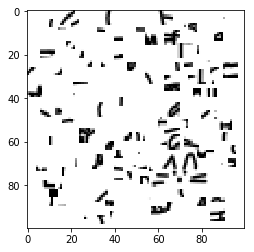

In [4]:
tmpImg = images[5000][1].reshape((100,100)).astype(np.uint8)
plt.imshow(tmpImg, cmap='gray_r')
plt.show()

In [5]:
# Try to find contours
from skimage import measure
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon


def getLongestContour(img):
    img_contours = measure.find_contours(img, 0.99, 'high')
    img_contours.sort(key=lambda x: len(x), reverse=True)
    return img_contours[0]

# need to wrap with try / except, for when contour is invalid 
def tryPolygonArea(contour):
    try:
        return Polygon(contour).area
    except:
        return 0

def getLargestContour(img):
    img_contours = measure.find_contours(img, 0.99, 'high')
    img_contours.sort(key=tryPolygonArea, reverse=True)
    return img_contours[0]
    

def overlayContour(img, contour):
    plt.imshow(img, cmap='gray_r')
    # Plot the longest contour
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2)
    plt.show()

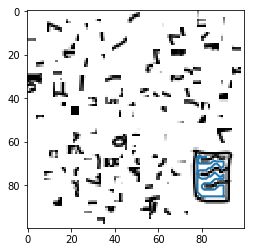

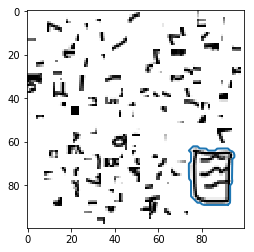

In [7]:
tmpImg = images[952][1].reshape((100,100)).astype(np.uint8)

longest_contour = getLongestContour(tmpImg)
overlayContour(tmpImg, longest_contour)
largest_contout = getLargestContour(tmpImg)
overlayContour(tmpImg, largest_contout)

In [8]:
# histogram of contours to find potentially noise

contour_lengths = np.zeros(len(tmpImg_contours))

for i, contour in enumerate(tmpImg_contours):
    contour_lengths[i] = float(len(contour))

plt.hist(contour_lengths, bins=20)
plt.show()

NameError: name 'tmpImg_contours' is not defined

### NOTE: this is bad for noise-only images (see index 5000)

#### maybe try shrinking the black edges then do contours?

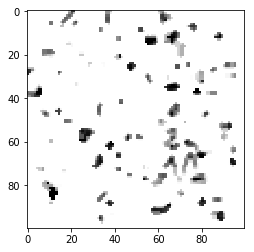

In [419]:
# Use some sort of naive filter (deprecated)
from skimage import filters

med_filter_tmpImg = filters.median(tmpImg, np.ones((3, 3)))

plt.imshow(med_filter_tmpImg, cmap='gray_r')

plt.show()

## Remove everything that is not inside of contour

In [576]:
def removeNoiseViaContour(oldImg, contour_type='longest'):
    if contour_type == 'longest':
        contour = getLongestContour(oldImg)
    elif contour_type == 'largest':
        contour = getLargestContour(oldImg)
    else:
        print("Invalid contour_type:", contour_type, ". Allowed values: longest, largest")
        raise
    polygon = Polygon(contour)
    #set to 0
    newImg = [[0 for j in range(len(oldImg[i]))] for i in range(len(oldImg))]
    #iterate through old image
    for i in range(len(oldImg)):
        for j in range(len(oldImg[i])):
            point = Point(i,j)
            if polygon.contains(point):
                newImg[i][j] = oldImg[i][j]
    return newImg

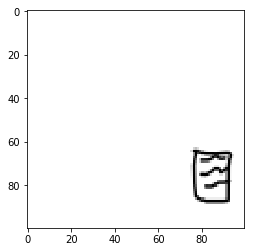

In [572]:
not_noise_img = removeNoiseViaContour(tmpImg)
plt.imshow(not_noise_img, cmap='gray_r')
plt.show()

## Remove everything outside of the bounding box of the contour

In [577]:
def boundingBoxOfContour(contour):
    minX = float("inf")
    minY = float("inf")
    maxX = -1
    maxY = -1
    for x,y in contour:
        if minX > x:
            minX = x
        if minY > y:
            minY = y
        if maxX < x:
            maxX = x
        if maxY < y:
            maxY = y
    return minX, minY, maxX,maxY

# Removes noise based off of the bounding box of the longest contour. Buffer is how much additional 
# space we want to provide beyond the bounding box.
# If buffer < 1, it will add buffer equal to the (largest side of bounding box * buffer)
def removeNoiseViaBoundingBox(oldImg, buffer = 0, contour_type='longest'):
    if contour_type == 'longest':
        contour = getLongestContour(oldImg)
    elif contour_type == 'largest':
        contour = getLargestContour(oldImg)
    else:
        print("Invalid contour_type:", contour_type, ". Allowed values: longest, largest")
        raise
    minX, minY, maxX, maxY = boundingBoxOfContour(contour)
    
    if (buffer < 1):
        maxLength = max(maxX - minX, maxY - minY)
        buffer = buffer * maxLength
    # overlayContour(oldImg, np.array([[minX, minY], [minX, maxY], [maxX, maxY], [minX, maxY], [minX, minY]]))
    
    newImg = [[0 for j in range(len(oldImg[i]))] for i in range(len(oldImg))]
        
    #iterate through old image
    for x in range(len(oldImg)):
        for y in range(len(oldImg[x])):
            if x >= (minX - buffer) and x <= (maxX + buffer) and y >= (minY - buffer) and y <= (maxY + buffer):
                newImg[x][y] = oldImg[x][y]
    return newImg

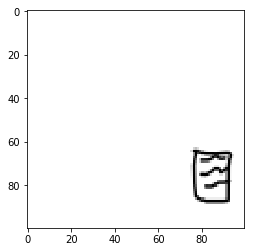

In [578]:
not_noise_img = removeNoiseViaBoundingBox(tmpImg)
plt.imshow(not_noise_img, cmap='gray_r')
plt.show()

## center, crop, rescale image

In [579]:
from scipy.ndimage import zoom

#Finds the first non-zero coordinate, and the last non-zero coordinate.
def boundingBox(img):
    minX = -1
    minY = -1
    maxX = -1
    maxY = -1
    for i, row in enumerate(img):
        nonZeroIndexes = np.nonzero(row)[0]
        if len(nonZeroIndexes) != 0:
            if minX == -1:
                minX = i
            if minY == -1 or minY > np.min(nonZeroIndexes):
                minY = np.min(nonZeroIndexes)
            if maxX < i:
                maxX = i
            if maxY < np.max(nonZeroIndexes):
                maxY = np.max(nonZeroIndexes)
    return (minX, minY), (maxX,maxY)

# Centers the image
def center(img):
    minCoord, maxCoord = boundingBox(img)
    xLength = maxCoord[0] - minCoord[0]
    yLength = maxCoord[1] - minCoord[1]
    newImg = [[0 for j in range(len(img[i]))] for i in range(len(img))]
    
    startX = int((len(img) - xLength) / 2)
    startY = int((len(img[0]) - yLength) / 2)
    for i,x in enumerate(range(startX, startX + xLength + 1)):
        for j,y in enumerate(range(startY, startY + yLength + 1)):
            newImg[x][y] = img[minCoord[0]+i][minCoord[1]+j]
    return newImg

# Crop out all of the white space. If you want square dimensions, then it will pad white space.
def cropWhite(img, isSquare = False):
    minCoord, maxCoord = boundingBox(img)
    xLength = maxCoord[0] - minCoord[0]
    yLength = maxCoord[1] - minCoord[1]
    if isSquare:
        xLength = max(xLength, yLength)
        yLength = max(xLength, yLength)
    
    newImg = [[0 for j in range(yLength + 1)] for i in range(xLength + 1)]
    for i in range(xLength + 1):
        for j in range(yLength + 1):
            # Check for case where we are out of bounds for cropped white + square
            if (minCoord[0] + i) >= len(img) or (minCoord[1] + j) >= len(img[i]):
                newImg[i][j] = 0
            else:
                newImg[i][j] = img[minCoord[0] + i][minCoord[1] + j]
    return newImg

# rescale image to square of height, width = dimension    
def rescale(img, dimension):
    cropped = cropWhite(img)
    height = len(cropped)
    width = len(cropped[0])
    zoomFactor = dimension / max(height, width)
    return zoom(img, zoomFactor, order=0)

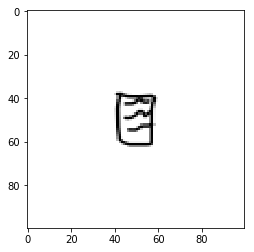

In [580]:
centered_img = center(not_noise_img)
plt.imshow(centered_img, cmap='gray_r')
plt.show()

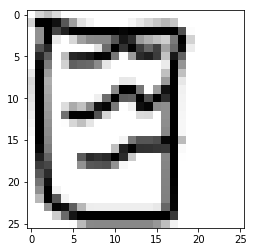

In [581]:
cropped = cropWhite(not_noise_img, True)
plt.imshow(cropped, cmap='gray_r')
plt.show()

In [582]:
def preprocessImg(img, noiseRemoveType='bounding_box', contour_type='longest', rescaleDimension = 40):
    if noiseRemoveType == 'bounding_box':
        filteredImg = removeNoiseViaBoundingBox(img, .2, contour_type)
    elif noiseRemoveType == 'longest_contour':
        filteredImg = removeNoiseViaContour(img, contour_type)
    else:
        print("Invalid noiseRemoveType:", noiseRemoveType, ". Allowed values: bounding_box, longest_contour")
        raise 
    croppedImg = cropWhite(filteredImg, True)
    centered_img = center(croppedImg)
    rescaled_img = rescale(centered_img, rescaleDimension)
    return rescaled_img

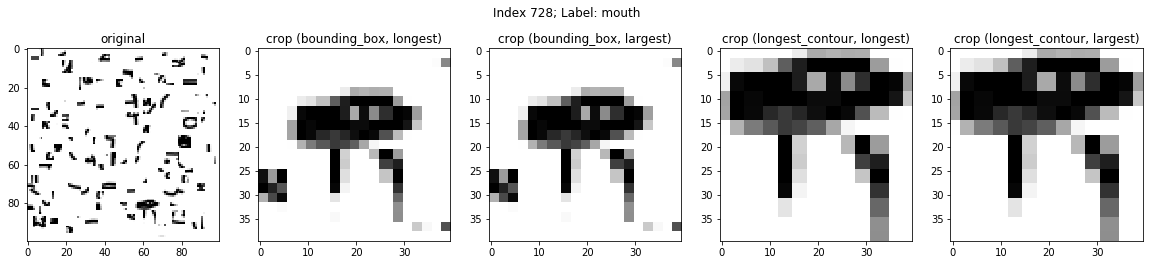

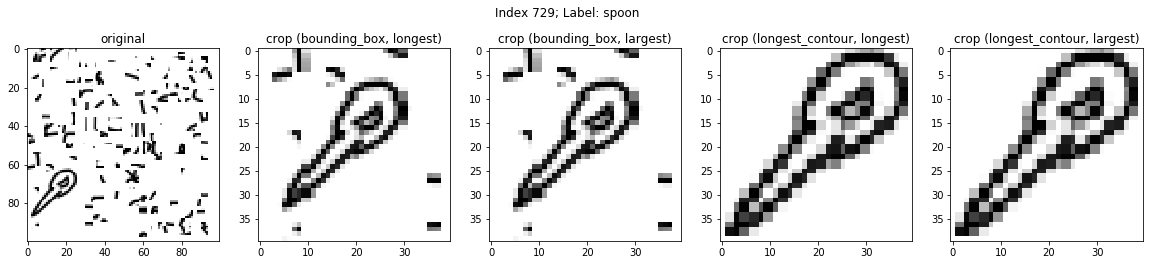

In [601]:
startI = 728
endI = 730
for i in range(startI, endI):
    img = images[i][1].reshape((100,100)).astype(np.uint8)
    
    
    f, axarr = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))
    f.suptitle("Index " + str(i) + "; Label: " + labels.at[i,'Category'])
    axarr[0].imshow(img, cmap='gray_r')
    axarr[0].set_title('original')
    j = 1
    for noiseType in ['bounding_box', 'longest_contour']:
        for contour in ['longest', 'largest']:
            processed = preprocessImg(img, noiseRemoveType=noiseType, contour_type=contour)
            axarr[j].imshow(processed, cmap='gray_r')
            title = 'crop (' + noiseType + ', ' + contour + ')'
            axarr[j].set_title(title)
            j+=1
    # plt.savefig("img/"+str(startI)+"-"+str(endI - 1)+"/Index_" + str(i) + "_Label_" + labels.at[i,'Category'] + '.png')
    plt.show()
